Import required Library

In [76]:
import torch
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [77]:
import matplotlib.pyplot as plt

Exercise with MNIST


In [78]:
train_dataset = datasets.MNIST(root='./MNIST/', train= True, transform=transforms.ToTensor(), download=True)
test_dataset = datasets.MNIST(root='./MNIST/', train=False, transform=transforms.ToTensor(), download= True)

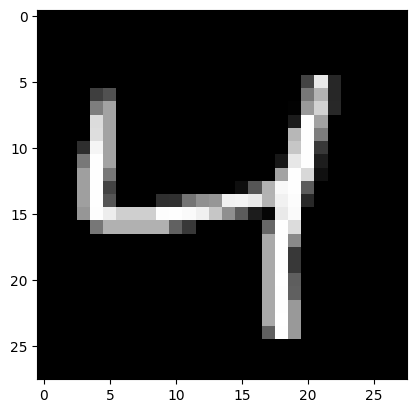

In [79]:
import matplotlib.pyplot as plt
plt.imshow(train_dataset[2][0].squeeze(), cmap='gray')

In [80]:
import random  
import numpy as np
seed = 21521109
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark  = False

In [81]:

train_Loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset)

Logistic Regression

In [82]:
import torch.nn as nn
import torch.nn.functional as F

In [83]:
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [84]:
class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        logits = self.linear(x)
        probs = F.softmax(logits, dim = 1)
        return logits, probs
    

In [89]:
def train_model(dataloader,model, init_lr, max_epoch):
    critetion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr = init_lr);
    loss_each_epoch = []
    model.train()
    for epoch in range(max_epoch):
        sum_loss = 0.0
        for (imgs, labels) in dataloader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0], -1);
            #forward
            logits , _ = model(imgs)
            loss = critetion(logits, labels)
            #backward
            optimizer.zero_grad()
            loss.backward()

            optimizer.step()

            sum_loss += loss.item()
        loss_each_epoch.append(sum_loss/len(dataloader.dataset))
        print(f'Epoch {epoch + 1}/{max_epoch}, Loss: {loss_each_epoch[epoch]:.2} ')
    return loss_each_epoch

In [90]:
clf_LR = LogisticRegression(input_dim=28*28, output_dim=10).to(device)
loss_each_epoch_LR = train_model(dataloader=train_Loader, model=clf_LR, init_lr=0.001, max_epoch=20)

Epoch 1/20, Loss: 0.03 
Epoch 2/20, Loss: 0.022 
Epoch 3/20, Loss: 0.018 
Epoch 4/20, Loss: 0.015 
Epoch 5/20, Loss: 0.014 
Epoch 6/20, Loss: 0.012 
Epoch 7/20, Loss: 0.012 
Epoch 8/20, Loss: 0.011 
Epoch 9/20, Loss: 0.01 
Epoch 10/20, Loss: 0.01 
Epoch 11/20, Loss: 0.0096 
Epoch 12/20, Loss: 0.0093 
Epoch 13/20, Loss: 0.009 
Epoch 14/20, Loss: 0.0088 
Epoch 15/20, Loss: 0.0086 
Epoch 16/20, Loss: 0.0084 
Epoch 17/20, Loss: 0.0083 
Epoch 18/20, Loss: 0.0081 
Epoch 19/20, Loss: 0.008 
Epoch 20/20, Loss: 0.0079 


In [168]:
def PlotLoss(loss_each_epoch, name: str) -> None:
    plt.plot(range(1,len(loss_each_epoch)+1), loss_each_epoch)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title(name)
    plt.show()

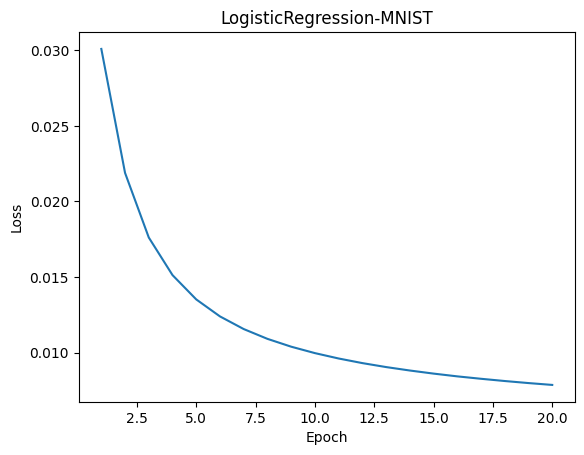

In [169]:
PlotLoss(loss_each_epoch_LR, 'LogisticRegression-MNIST')

In [94]:
def model_evaluation(data_loader, model):
    nCorrects = 0;
    model.eval()
    with torch.no_grad():
        for (imgs, labels) in data_loader:
            imgs, labels = imgs.to(device), labels.to(device)
            imgs = imgs.reshape(imgs.shape[0],-1)

            #forward
            _, probs = model(imgs)
            _, y_pred = probs.max(1)
            nCorrects += (y_pred == labels).sum()
    print(f'We got {nCorrects.item()}/{len(data_loader.dataset)} correct. Accuracy = {nCorrects.item()/len(data_loader.dataset) * 100:.2f}%')


In [96]:
print('LogisticRegressin (Train accuracy)')
model_evaluation(data_loader=train_Loader, model=clf_LR)

LogisticRegressin (Train accuracy)
We got 52545/60000 correct. Accuracy = 87.58%


In [97]:
print('LogisticRegressin (Test accuracy)')
model_evaluation(data_loader=test_loader, model=clf_LR)

LogisticRegressin (Test accuracy)
We got 8840/10000 correct. Accuracy = 88.40%


In [102]:
def Model_plot(datasets, model, imgrow = 10, nrow = 5):
    fig = plt.figure()
    for index in range(1, nrow*imgrow + 1):
        plt.subplot(nrow, imgrow, index)
        plt.axis('off')
        plt.imshow(datasets.data[index], cmap='gray_r')

        with torch.no_grad():
            clf_LR.eval()
            X = datasets[index][0].reshape(datasets[index][0].shape[0], -1).to(device)
            _, probs = model(X)
        title = f'{torch.argmax(probs)} ({torch.max(probs*100):.0f}%)'
        plt.title(title, fontsize = 7)
    fig.suptitle('LogisticRegressin - predictions')
    fig.show()

C:\Users\drawt\AppData\Local\Temp\ipykernel_1808\1143753929.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


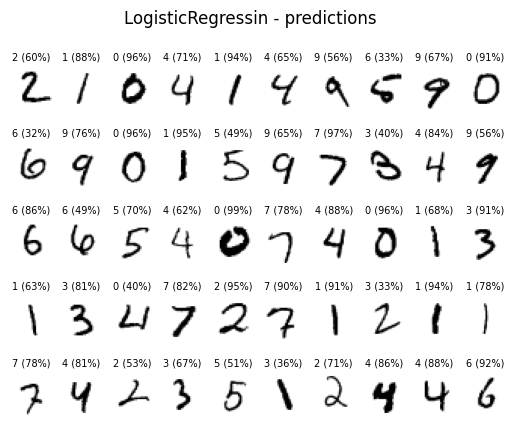

In [103]:
Model_plot(test_dataset, clf_LR)

MLP with pytorch

In [104]:
class MLP(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.classifier = nn.Sequential(nn.Linear(input_dim,100),
                                        nn.ReLU(),
                                        nn.Linear(100,25),
                                        nn.ReLU(),
                                        nn.Linear(25,output_dim)
        )
    def forward(self,x):
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs        

In [113]:
clf_MLP = MLP(input_dim=28*28, output_dim=10).to(device)
clf_MLP

MLP(
  (classifier): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=10, bias=True)
  )
)

In [114]:
loss_each_epoch_MLP = train_model(train_Loader, clf_MLP, 0.001, 20)

Epoch 1/20, Loss: 0.036 
Epoch 2/20, Loss: 0.036 
Epoch 3/20, Loss: 0.035 
Epoch 4/20, Loss: 0.034 
Epoch 5/20, Loss: 0.033 
Epoch 6/20, Loss: 0.03 
Epoch 7/20, Loss: 0.027 
Epoch 8/20, Loss: 0.023 
Epoch 9/20, Loss: 0.02 
Epoch 10/20, Loss: 0.017 
Epoch 11/20, Loss: 0.014 
Epoch 12/20, Loss: 0.012 
Epoch 13/20, Loss: 0.011 
Epoch 14/20, Loss: 0.01 
Epoch 15/20, Loss: 0.0096 
Epoch 16/20, Loss: 0.009 
Epoch 17/20, Loss: 0.0085 
Epoch 18/20, Loss: 0.0081 
Epoch 19/20, Loss: 0.0078 
Epoch 20/20, Loss: 0.0075 


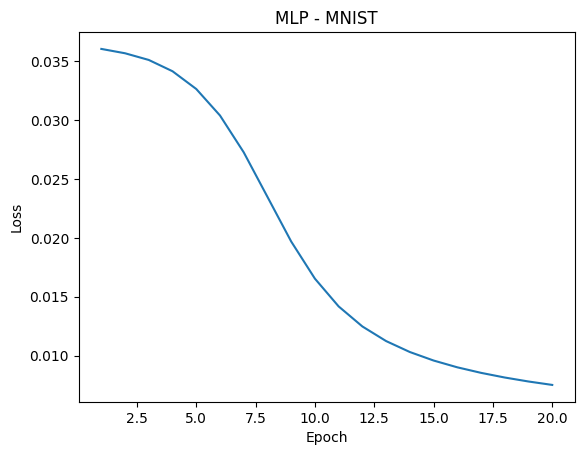

In [170]:
PlotLoss(loss_each_epoch_MLP, "MLP - MNIST")

In [117]:
print('MLP (Train accuracy)')
model_evaluation(data_loader=train_Loader, model=clf_MLP)

MLP (Train accuracy)
We got 52390/60000 correct. Accuracy = 87.32%


In [118]:
print('MLP (test accuracy)')
model_evaluation(test_loader, clf_MLP)

MLP (test accuracy)
We got 8769/10000 correct. Accuracy = 87.69%


C:\Users\drawt\AppData\Local\Temp\ipykernel_1808\1143753929.py:15: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


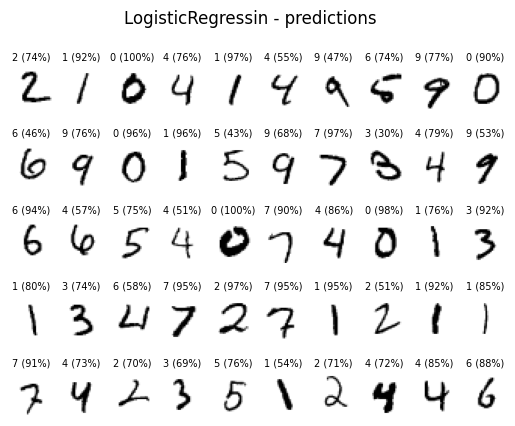

In [119]:
Model_plot(test_dataset, clf_MLP)

Cake dataset

In [147]:
import os
import cv2 
root_dir = './images'

In [148]:
list_folder = os.listdir(root_dir)
list_folder

['banhmi', 'cookie', 'croissaint', 'donut', 'pizza', 'pretzel']

In [149]:
X_cake, y_cake = [], []

In [150]:
for folder in list_folder:
    list_img_path = os.listdir(os.path.join(root_dir,folder))
    for img_path in list_img_path:
        img_matrix = cv2.imread(root_dir+'/'+folder+'/'+img_path,0)
        X_cake.append([img_matrix])
        y_cake.append(folder)

Normalize the value of each pixel from [0,255] to [0,1] 

In [151]:
X_cake = np.array(X_cake)/255

Encode label to numeric value

In [152]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_cake = le.fit_transform(y_cake)

In [157]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_cake,y_cake, test_size=0.3, random_state=seed)

In [158]:
print(X_train.shape)

(210, 1, 500, 500)


Convert data from list to nparray then convert from nparray to tensor

In [159]:
X_train, X_test = np.array(X_train), np.array(X_test)
y_train, y_test = np.array(y_train), np.array(y_test)



In [160]:
X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_train = torch.from_numpy(y_train)
y_test = torch.from_numpy(y_test)

print(len(X_train))

210


In [161]:
from torch.utils.data import TensorDataset

#create Train_dataset, test_dataset
train_dataset_cake = TensorDataset(X_train, y_train)
test_dataset_cake = TensorDataset(X_test, y_test)
#create train loader, test loader
train_loader_cake = DataLoader(train_dataset_cake, batch_size=16, shuffle=True)
test_loader_cake = DataLoader(test_dataset_cake)

In [162]:
print(train_dataset_cake[0])

(tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]]), tensor(2))


In [163]:
clf_LR_1 = LogisticRegression(input_dim=250000, output_dim=6).to(device)
loss_each_epoch_LR_1 = train_model(train_loader_cake, clf_LR_1, 0.001,200)

Epoch 1/200, Loss: 5.2 
Epoch 2/200, Loss: 5.0 
Epoch 3/200, Loss: 5.2 
Epoch 4/200, Loss: 4.0 
Epoch 5/200, Loss: 2.8 
Epoch 6/200, Loss: 1.7 
Epoch 7/200, Loss: 1.4 
Epoch 8/200, Loss: 2.1 
Epoch 9/200, Loss: 1.5 
Epoch 10/200, Loss: 1.5 
Epoch 11/200, Loss: 0.98 
Epoch 12/200, Loss: 0.8 
Epoch 13/200, Loss: 0.35 
Epoch 14/200, Loss: 0.39 
Epoch 15/200, Loss: 0.84 
Epoch 16/200, Loss: 0.91 
Epoch 17/200, Loss: 0.26 
Epoch 18/200, Loss: 0.51 
Epoch 19/200, Loss: 0.37 
Epoch 20/200, Loss: 0.26 
Epoch 21/200, Loss: 0.23 
Epoch 22/200, Loss: 0.25 
Epoch 23/200, Loss: 0.9 
Epoch 24/200, Loss: 0.11 
Epoch 25/200, Loss: 0.07 
Epoch 26/200, Loss: 0.29 
Epoch 27/200, Loss: 0.18 
Epoch 28/200, Loss: 0.47 
Epoch 29/200, Loss: 0.051 
Epoch 30/200, Loss: 0.25 
Epoch 31/200, Loss: 0.64 
Epoch 32/200, Loss: 0.29 
Epoch 33/200, Loss: 0.098 
Epoch 34/200, Loss: 0.093 
Epoch 35/200, Loss: 0.086 
Epoch 36/200, Loss: 0.041 
Epoch 37/200, Loss: 0.12 
Epoch 38/200, Loss: 0.025 
Epoch 39/200, Loss: 0.067 


In [164]:
clf_MLP_1 = MLP(input_dim=250000, output_dim=6).to(device)
loss_each_epoch_MLP_1 = train_model(train_loader_cake, clf_MLP_1, 0.001, 200)

Epoch 1/200, Loss: 0.12 
Epoch 2/200, Loss: 0.12 
Epoch 3/200, Loss: 0.12 
Epoch 4/200, Loss: 0.12 
Epoch 5/200, Loss: 0.12 
Epoch 6/200, Loss: 0.12 
Epoch 7/200, Loss: 0.12 
Epoch 8/200, Loss: 0.12 
Epoch 9/200, Loss: 0.11 
Epoch 10/200, Loss: 0.12 
Epoch 11/200, Loss: 0.11 
Epoch 12/200, Loss: 0.11 
Epoch 13/200, Loss: 0.11 
Epoch 14/200, Loss: 0.11 
Epoch 15/200, Loss: 0.11 
Epoch 16/200, Loss: 0.11 
Epoch 17/200, Loss: 0.11 
Epoch 18/200, Loss: 0.1 
Epoch 19/200, Loss: 0.1 
Epoch 20/200, Loss: 0.1 
Epoch 21/200, Loss: 0.098 
Epoch 22/200, Loss: 0.097 
Epoch 23/200, Loss: 0.095 
Epoch 24/200, Loss: 0.093 
Epoch 25/200, Loss: 0.091 
Epoch 26/200, Loss: 0.089 
Epoch 27/200, Loss: 0.086 
Epoch 28/200, Loss: 0.084 
Epoch 29/200, Loss: 0.081 
Epoch 30/200, Loss: 0.079 
Epoch 31/200, Loss: 0.078 
Epoch 32/200, Loss: 0.074 
Epoch 33/200, Loss: 0.071 
Epoch 34/200, Loss: 0.07 
Epoch 35/200, Loss: 0.072 
Epoch 36/200, Loss: 0.067 
Epoch 37/200, Loss: 0.067 
Epoch 38/200, Loss: 0.064 
Epoch 3

In [165]:
print('LogisticRegression(Train accuracy)')
model_evaluation(data_loader=train_loader_cake, model= clf_LR_1)
print('LogisticRegression(test accuracy)')
model_evaluation(data_loader=test_loader_cake, model= clf_LR_1)

LogisticRegression(Train accuracy)
We got 210/210 correct. Accuracy = 100.00%
LogisticRegression(test accuracy)
We got 84/90 correct. Accuracy = 93.33%


In [166]:
print('MLP(Train accuracy)')
model_evaluation(data_loader=train_loader_cake, model= clf_MLP_1)
print('MLP(Test accuracy)')
model_evaluation(data_loader=test_loader_cake, model= clf_MLP_1)

MLP(Train accuracy)
We got 206/210 correct. Accuracy = 98.10%
MLP(Test accuracy)
We got 83/90 correct. Accuracy = 92.22%


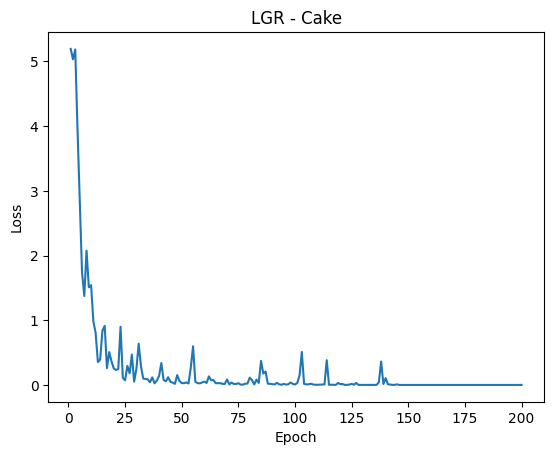

In [171]:
PlotLoss(loss_each_epoch_LR_1, "LGR - Cake")

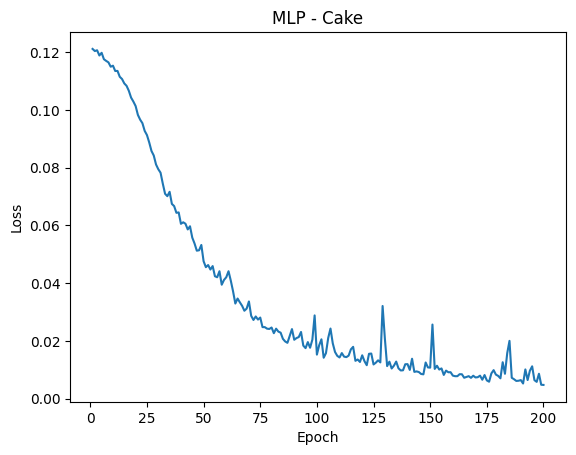

In [172]:
PlotLoss(loss_each_epoch_MLP_1, "MLP - Cake")